In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

import random

import numpy as np
import gym

env_name = "Skiing-v0"
env = gym.make(env_name)

In [2]:
def render(x, step=0):
  display.clear_output(wait=True)

  plt.figure(figsize=(6, 6))
  plt.clf()
  plt.axis("off")
  plt.title("step: %d" % step)
  plt.imshow(x, cmap=plt.cm.gray)
  plt.pause(0.001)   # pause for plots to update

In [3]:
# Objects can be distinquished by RGB codes.
# Player: [214, 92, 92]
# Flags (blue): [66, 72, 200]
# Flags (red): [184, 50, 50]

def get_pos_player(observe):
  ids = np.where(np.sum(observe == [214, 92, 92], -1) == 3)
  return ids[0].mean(), ids[1].mean()

def get_pos_flags(observe):
  if np.any(np.sum(observe == [184, 50, 50], -1) == 3):
    ids = np.where(np.sum(observe == [184, 50, 50], -1) == 3)
    return ids[0].mean(), ids[1].mean()
  else:
    base = 0
    ids = np.where(np.sum(observe[base:-60] == [66, 72, 200], -1) == 3)
    return ids[0].mean() + base, ids[1].mean()

def get_speed(observe, observe_old):
  # As the vertical location of the player is not changed, 
  # I estimate the vertical speed by measuring how much frames are shifted up.
  min_val = np.inf
  min_idx = 0
  for k in range(0, 7):
    val = np.sum(np.abs(observe[54:-52,8:152] - observe_old[54+k:-52+k,8:152]))
    if min_val > val:
      min_idx = k
      min_val = val
  return min_idx

In [4]:
observe = env.reset()
step = 0
done = False

# states
r_a, c_a = get_pos_player(observe)
r_f, c_f = get_pos_flags(observe)
r_a_old, c_a_old = r_a, c_a
observe_old = observe

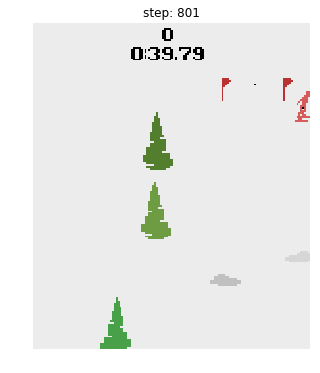

In [5]:
while not done:
  step += 1
  
  v_f = np.arctan2(r_f - r_a, c_f - c_a) # direction from player to target
  spd = get_speed(observe, observe_old)
  v_a = np.arctan2(spd, c_a - c_a_old) # speed vector of the player
  r_a_old, c_a_old = r_a, c_a
  observe_old = observe
  if spd == 0 and (c_a - c_a_old) == 0:
    # no movement
    act = np.random.choice(3, 1)[0]
  else:
    if v_f - v_a < -0.1:
      act = 1
    elif v_f - v_a > 0.1:
      act = 2
    else:
      act = 0
      
  observe, reward, done, info = env.step(act)
  
  r_a, c_a = get_pos_player(observe)
  r_f, c_f = get_pos_flags(observe)
  observe[int(r_a), int(c_a)] = [0, 0, 0] # draw a dot to check the player's location.
  observe[int(r_f), int(c_f)] = [0, 0, 0] # draw a dot to check the target's location.
  if step % 3 == 0:
    render(observe[28:-52,8:152], step)